##### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

참고 : https://www.tensorflow.org/tutorials/generative/cyclegan   
번역 : 코어닷투데이 http://github.com/coredottoday/DeepLearningTextBook/

# CycleGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cyclegan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

이 노트북은 CycleGAN이라고도 하는 [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593)에 설명된 것처럼 조건부 GAN을 사용하여 쌍으로 연결되지 않은 이미지 간 변환을 보여줍니다. 이 논문은 한 쌍의 훈련 예제가 없을 때 하나의 이미지 도메인의 특성을 포착하고 이러한 특성이 다른 이미지 도메인으로 어떻게 변환될 수 있는지 알아낼 수있는 방법을 제안합니다.

이 노트북은 독자가 [Pix2Pix tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix)에서 배울 수 있는 Pix2Pix에 익숙하다고 가정합니다. CycleGAN의 코드는 비슷하며, 주된 차이점은 추가 손실 함수와 쌍으로 연결되지 않은 훈련 데이터를 사용한다는 점입니다.

CycleGAN은 주기 일관성 손실을 사용하여 쌍으로 연결된 데이터 없이도 훈련을 수행할 수 있습니다. 즉, 소스와 대상 도메인 사이에서 일대일 매핑 없이 한 도메인에서 다른 도메인으로 변환할 수 있습니다.

이를 통해 사진 향상, 이미지 색상 지정, 스타일 전송 등과 같은 많은 흥미로운 작업을 수행할 수 있습니다. 소스와 대상 데이터세트(단순히 이미지 디렉토리)만 있으면 됩니다.


![Output Image 1](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_1.png?raw=1)
![Output Image 2](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_2.png?raw=1)

## 입력 파이프라인 설정하기

생성기와 판별자 가져오기를 지원하는 [tensorflow_examples](https://github.com/tensorflow/examples) 패키지를 설치합니다.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-3yuoncs4
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-3yuoncs4
  Created wheel for tensorflow-examples: filename=tensorflow_examples-003510183c4a425236788b44d153b92fb4c7423a_-cp37-none-any.whl size=270854 sha256=2f64d8f24094815683cd44b5e2ce16652d02dfdb1ff6d9b852017026bbfedd9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xs7ie42g/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## 입력 파이프라인


이 튜토리얼에서는 말의 이미지에서 얼룩말의 이미지로 변환하도록 모델을 훈련합니다. 이 데이터세트 및 이와 유사한 데이터세트는 [here](https://www.tensorflow.org/datasets/catalog/cycle_gan)에서 찾을 수 있습니다.

[논문](https://arxiv.org/abs/1703.10593)에 언급된 바와 같이 훈련 데이터세트에 임의의 지터링 및 미러링을 적용합니다. 이것은 과대적합을 피하는 이미지 강화 기법들입니다.

이 작업은 [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)에서 수행한 것과 비슷합니다.

- 무작위 지터링(jittering)에서 이미지는 286 x 286 크기로 조정된 후 256 x 256로 무작위로 잘립니다.
- 무작위 미러링에서는 이미지가 좌우로 무작위로 뒤집힙니다.

In [ ]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete9FD67D/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete9FD67D/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete9FD67D/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete9FD67D/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

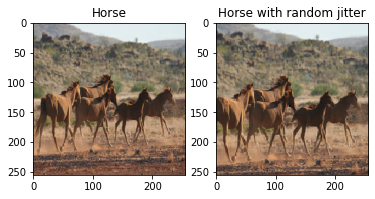

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

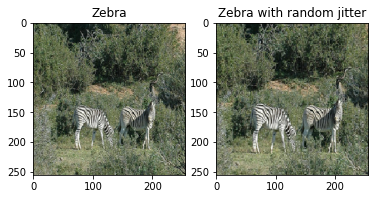

In [ ]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

## Pix2Pix 모델 가져오기 및 재사용하기

설치된 [tensorflow_examples](https://github.com/tensorflow/examples) 패키지를 통해 [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py)에서 사용되는 생성기와 판별자를 가져옵니다.

이 튜토리얼에서 사용된 모델 아키텍처는 [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py)에서 사용된 것과 매우 유사합니다. 몇 가지 차이점은 다음과 같습니다.

* Cyclegan은 배치 정규화([batch normalization](https://arxiv.org/abs/1502.03167)) 대신 인스턴스 정규화([instance normalization](https://arxiv.org/abs/1607.08022))를 사용합니다.
* CycleGAN 논문([paper](https://arxiv.org/abs/1703.10593))에서는 수정된 resnet 기반 생성기를 사용합니다. 이 튜토리얼에서는 단순화를 위해 수정된 unet 생성기를 사용합니다.


여기서는 2개의 생성기(G 및 F)와 2개의 판별자(X 및 Y)를 훈련합니다.

* 생성기 `G`는 이미지 `X`를 이미지 `Y`로 변환하는 방법을 학습합니다. 
* 생성기 `F`는 이미지 `Y`를 이미지 `X`로 변환하는 방법을 학습합니다. 
* 판별자 `D_X`는 이미지 `X`와 생성된 이미지 `X( F(Y) )`를 구별하는 방법을 학습합니다.
* 판별자 `D_Y`는 이미지 `Y`와 생성된 이미지 `Y(G(X))`를 구별하는 방법을 학습합니다.


![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

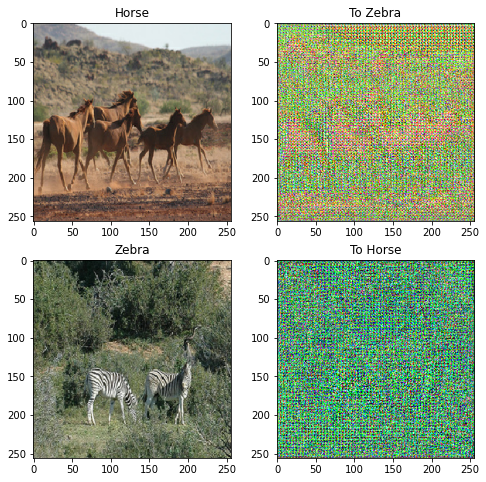

In [ ]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

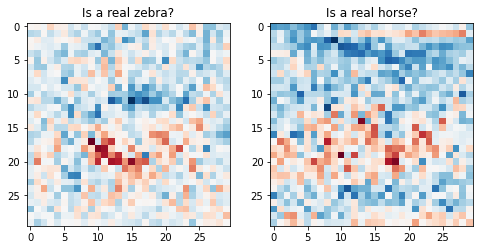

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

## 손실 함수 (Loss functions)

CycleGAN에는 훈련할 쌍으로 연결된 데이터가 없으므로 훈련 중에 입력 x와 대상 y의 쌍이 의미가 있다는 보장이 없습니다. 따라서 네트워크가 올바른 매핑을 학습하도록 강제하기 위해 저자들은 주기 일관성 손실을 제안합니다.

판별자 손실 및 생성기 손실은 [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator)에 사용된 것과 유사합니다.

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

주기 일관성은 결과가 원래 입력에 가까워야 함을 의미합니다. 예를 들어 문장을 영어에서 프랑스어로 번역한 다음 다시 프랑스어에서 영어로 번역하면 결과 문장은 원래 문장과 같아야 합니다.

주기 일관성 손실(cycle consistency loss)에서,

- 이미지 $X$는 생성기 $G$를 통해 전달되어 $\hat{Y}$의 생성된 이미지가 만들어집니다.
- $\hat{Y}$의 생성된 이미지는 생성기 $F$를 통해 전달되어 $\hat{X}$의 순환 이미지를 생성합니다.
- $X$ 및 $\hat{X}$ 사이에서 평균 절대 오차가 계산됩니다.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

위에서 볼 수 있듯이 생성기 $G$는 이미지 $X$를 이미지 $Y$로 변환하는 역할을 합니다. ID 손실은 이미지 $Y$를 생성기 $G$에 공급하면 실제 이미지 $Y$ 또는 이미지 $Y$에 가까운 이미지를 생성해야 한다고 지시합니다.

만약 말(horse) 이미지에 대해 zebra-to-horse 모델을 실행하거나 얼룩말(zebra)에서 horse-to-zebra 모델을 실행하는 경우, 이미지에 이미 대상 클래스가 포함되어 있으므로 이미지를 많이 수정하지 않아야 합니다.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

모든 생성기 및 판별자의 옵티마이저를 초기화합니다.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## 체크포인트

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## 훈련하기

참고: 이 예제 모델은 이 튜토리얼에 적합한 훈련 시간을 유지하기 위해 논문(200)보다 적은 epoch(40)를 대상으로 훈련합니다. 따라서 예측 정확성이 떨어질 수 있습니다.

In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

훈련 루프가 복잡해 보이지만 네 가지 기본 단계로 구성됩니다.

- 예측을 얻습니다.
- 손실을 계산합니다.
- 역전파를 사용하여 그래디언트를 계산합니다.
- 그래디언트를 옵티마이저에 적용합니다.

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

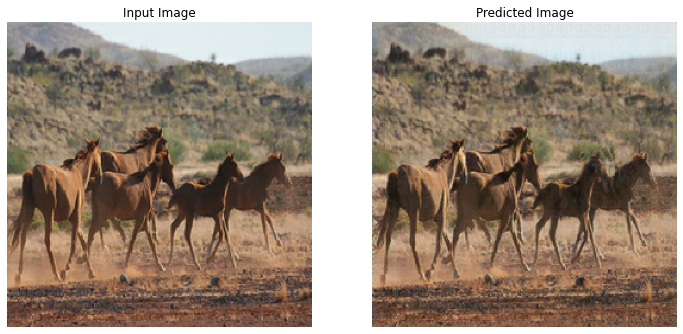

Saving checkpoint for epoch 40 at ./checkpoints/train/ckpt-8
Time taken for epoch 40 is 243.2236943244934 sec



In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## 테스트 데이터셋을 사용하여 생성하기

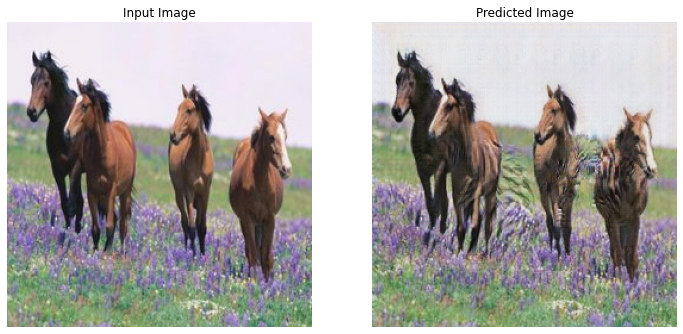

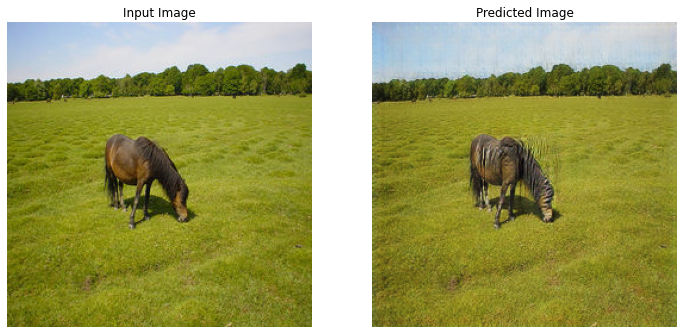

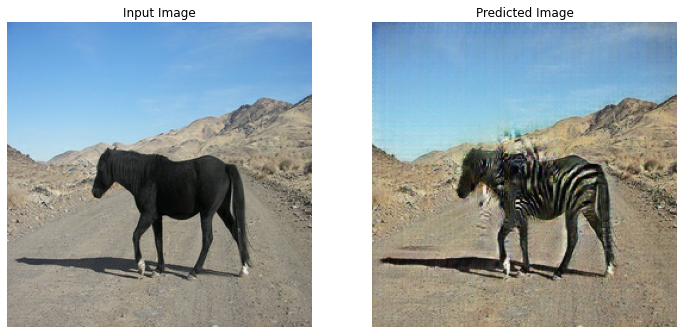

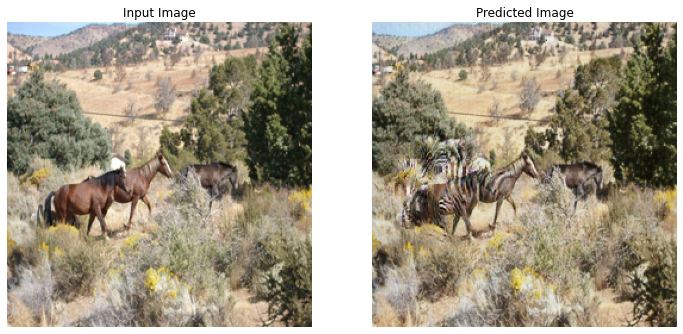

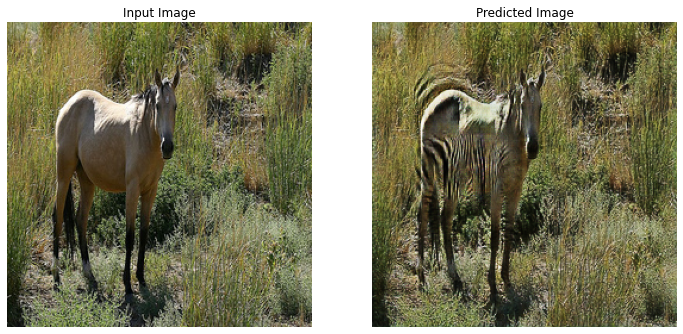

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

## 다음 단계

이 튜토리얼에서는 [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) 튜토리얼에서 구현된 생성기 및 판별자부터 시작하여 CycleGAN을 구현하는 방법을 알아보았습니다. 다음 단계에서는 [TensorFlow 데이터셋](https://www.tensorflow.org/datasets/catalog/cycle_gan)과 다른 데이터셋을 이용해 볼 수 있습니다.

결과를 개선하기 위해 더 많은 epoch 동안 훈련하거나 여기에 사용된 U-Net 생성기 대신 [논문](https://arxiv.org/abs/1703.10593)에 사용된 수정된 ResNet 생성기를 구현할 수도 있습니다.